In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from gensim.utils import simple_preprocess
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

# Load data

In [2]:
df = pd.read_parquet("df.parquet")

In [218]:
df.shape

(3292, 16)

In [219]:
df[df["premium"]==1].shape

(1644, 16)

In [220]:
df[df["premium"]==0].shape

(1648, 16)

In [221]:
df.columns

Index(['record_id', 'product', 'description', 'sub_category', 'brand',
       'company', 'company_parent', 'market_country', 'store_name',
       'store_type', 'import_status', 'unit_price', 'percentile', 'premium',
       'doc_vec', 'description_token'],
      dtype='object')

In [228]:
class_labels = ["budget", "premium"]

# Descriptive analysis
## Summary statistics

In [29]:
# top companies with premium products
df[df["premium"]==1].groupby(["company_parent"])[["record_id"]].count().sort_values("record_id", ascending=False).reset_index()[0:10]

,company_parent,record_id
0,L'Oréal,129
1,LVMH,104
2,Estée Lauder,99
3,QMS Medicosmetics,42
4,Babor Cosmetics,40
5,Shiseido,28
6,Molecular Cosmetics,27
7,Alticor,27
8,L'Occitane,26
9,Unilever,22


In [30]:
# top companies with budget products
df[df["premium"]==0].groupby(["company_parent"])[["record_id"]].count().sort_values("record_id", ascending=False).reset_index()[0:10]

,company_parent,record_id
0,Avon,110
1,DM Drogerie Markt,107
2,Beiersdorf,85
3,Lidl,75
4,Unilever,72
5,Aldi Group,48
6,L'Oréal,47
7,Johnson & Johnson,46
8,Dirk Rossmann,39
9,Auchan,29


In [32]:
# top countries with premium products
df[df["premium"]==1].groupby(["market_country"])[["record_id"]].count().sort_values("record_id", ascending=False).reset_index()[0:10]

,market_country,record_id
0,UK,657
1,Germany,510
2,France,412
3,Italy,11
4,Norway,9
5,Switzerland,8
6,Netherlands,7
7,Spain,7
8,Finland,3
9,Denmark,3


In [33]:
# top countries with budget products
df[df["premium"]==0].groupby(["market_country"])[["record_id"]].count().sort_values("record_id", ascending=False).reset_index()[0:10]

,market_country,record_id
0,Germany,190
1,Spain,166
2,France,154
3,Poland,153
4,Russia,131
5,UK,94
6,Italy,88
7,Austria,76
8,Denmark,61
9,Turkey,50


In [36]:
# top categories with premium products
df[df["premium"]==1].groupby(["sub_category"])[["record_id"]].count().sort_values("record_id", ascending=False).reset_index()

,sub_category,record_id
0,Face/Neck Care,1014
1,Eye Care,314
2,Lip Care,212
3,Body Care,35
4,Sets,32
5,Sun - Sun/Sunbed Exposure,23
6,Hand/Nail Care,8
7,Sun - Self-Tanning,3
8,Eye - Cleansers,1
9,Foot Care,1


In [37]:
# top countries with budget products
df[df["premium"]==0].groupby(["sub_category"])[["record_id"]].count().sort_values("record_id", ascending=False).reset_index()

,sub_category,record_id
0,Body Care,847
1,Face/Neck Care,351
2,Hand/Nail Care,187
3,Nail Enamel Removers,73
4,Foot Care,69
5,Sun - After Sun,42
6,Sun - Sun/Sunbed Exposure,29
7,Eye - Cleansers,24
8,Sets,20
9,Sun - Self-Tanning,5


In [73]:
description_size = np.array([len(df.description_token[i]) for i in df.index])
description_size.shape

(3292,)

In [79]:
description_size.max()

757

In [69]:
np.where(description_size == 80)

(array([1039]),)

In [72]:
len(df.description_token[1039])
#df.description_token[1039]

8

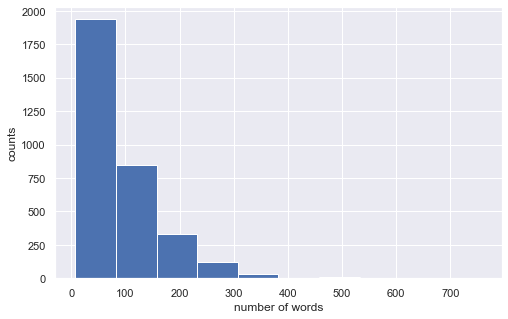

In [76]:
plt.figure(figsize=(8,5))
plt.hist(description_size)
plt.xlabel("number of words")
plt.ylabel("counts")
plt.show()
plt.close()

## Cosine similarity

In [4]:
# premium vs budget
cosine_similarity(df.doc_vec[0].reshape(1, -1), df.doc_vec[3291].reshape(1, -1))

array([[0.18499798]], dtype=float32)

In [4]:
# premium
cosine_similarity(df.doc_vec[0].reshape(1, -1), df.doc_vec[50].reshape(1, -1))

array([[0.1084419]], dtype=float32)

In [169]:
# budget
cosine_similarity(df.doc_vec[3290].reshape(1, -1), df.doc_vec[3291].reshape(1, -1))

array([[0.1753322]], dtype=float32)

## PCA on document vectors

In [40]:
# convert pandas series to array (to format dimention)
doc_vec = np.array([df.doc_vec[i] for i in df.index])
pca_mod = PCA().fit_transform(doc_vec)[:, :3]
doc_vec.shape
#pca_mod.shape

(3292, 300)

In [35]:
df_pca = pd.DataFrame(pca_mod)
df_pca["premium"] = df["premium"]
classes = {0:"budget", 1:"premium"}
df_pca["classes"] = df_pca.premium.apply(lambda x: classes[x])
colors = {0:"mediumpurple", 1:"coral"}
df_pca["colors"] = df_pca.premium.apply(lambda x: colors[x])
#df_pca

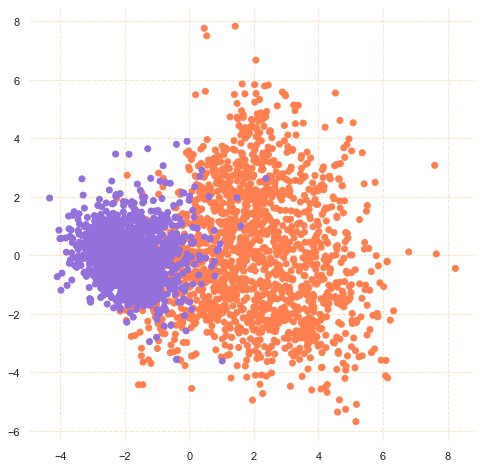

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.patch.set_facecolor("white")
plt.grid(color="bisque", linestyle="--", linewidth=1)
fig = plt.scatter(df_pca[0], df_pca[1], c=df_pca.colors)
#plt.scatter(df_pca[df_pca.premium==1][0], df_pca[df_pca.premium==1][1], c=df_pca[df_pca.premium==1].colors)
#plt.savefig("pca_2d.jpeg", dpi=300)
plt.show()
plt.close()

In [19]:
fig = px.scatter_3d(df_pca, x=0, y=1, z=2, color="classes", width=800, height=800)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(template="plotly_white", legend_orientation="h")
#fig.update_layout(legend=dict(yanchor="bottom", y=-0.6, xanchor="left", x=0))
fig.show()

## TF-IDF

In [257]:
description_stem = np.array([" ".join(df.description_token[i]) for i in df.index])
description_stem.shape

(3292,)

In [297]:
tfidf_vec_p = TfidfVectorizer()
tfidf_vec_p.fit_transform(description_stem[0:1644])
len(tfidf_vec_p.get_feature_names())

6968

In [296]:
tfidf_vec_all = TfidfVectorizer()
tfidf_vec_all.fit_transform(description_stem)
len(tfidf_vec_all.get_feature_names())

9709

# Classification

## Naive Bayes

In [4]:
# create training and test sets (using stemmed product descriptions)
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(description_stem, df.premium, test_size=0.2, random_state=1)

In [23]:
type(X_train_nb[0])

numpy.str_

In [5]:
nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
nb_model.fit(X_train_nb, y_train_nb)
y_pred_nb = nb_model.predict(X_test_nb)

In [7]:
mat_nb = confusion_matrix(y_pred_nb, y_test_nb)
mat_nb

array([[310,   1],
       [  7, 341]])

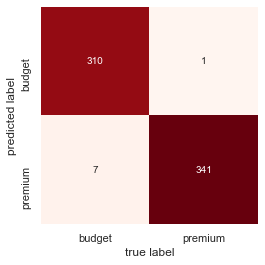

In [143]:
plt.figure(figsize=(4,4))
sns.heatmap(mat_nb, cmap="Reds", square=True, annot=True, fmt="d", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("true label")
plt.ylabel("predicted label");

In [9]:
print("Test accuracy: %f" %accuracy_score(y_test_nb, y_pred_nb))
print("Test F1 score: %f" %f1_score(y_test_nb, y_pred_nb))

Test accuracy: 0.987860
Test F1 score: 0.988406


In [185]:
def clean_input(sample_input):
    tokens = simple_preprocess(sample_input)
    token_clean = []
    for token in tokens:
        if token not in stop_words:
            token = PorterStemmer().stem(token)
            token_clean.append(token)

    sample_clean = " ".join(token_clean)
    return np.array([sample_clean])

In [187]:
# output 0 or 1
nb_model.predict(clean_input(sample_1))[0]

0

In [215]:
# output probabilities for both classes
nb_model.predict_proba(clean_input(sample_2))

array([[0.02768454, 0.97231546]])

In [188]:
def nb_predict(sample_input, model):
    label = model.predict(clean_input(sample_input))[0]
    if label == 0: return "budget"
    elif label == 1: return "premium"


In [189]:
sample_1 = "This product moisturizes and relaxes skin."
nb_predict(sample_1, nb_model)

'budget'

In [190]:
sample_2 = "This product rejuvenates and reduces fine lines."
nb_predict(sample_2, nb_model)

'premium'

## Logistic regression

In [69]:
# create training and test sets (using document vectors)
X_train, X_test, y_train, y_test = train_test_split(doc_vec, df.premium, test_size=0.2, random_state=1)

In [38]:
X_train.shape

(2633, 300)

In [115]:
X_test.shape

(659, 300)

In [70]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

In [71]:
print("Number of premium labels in the test set: %d" %sum(y_test==1))
print("Predicted number of premium labels: %d" %sum(y_pred_log==1))

Number of premium labels in the test set: 342
Predicted number of premium labels: 342


In [72]:
mat_log = confusion_matrix(y_pred_log, y_test)
mat_log

array([[305,  12],
       [ 12, 330]])

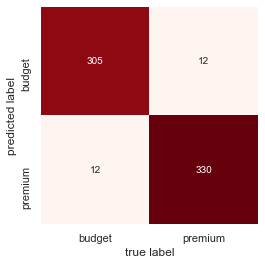

In [73]:
plt.figure(figsize=(4,4))
sns.heatmap(mat_log, cmap="Reds", square=True, annot=True, fmt="d", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("true label")
plt.ylabel("predicted label");

In [75]:
print("Test accuracy: %f" %accuracy_score(y_test, y_pred_log))
print("Test F1 score: %f" %f1_score(y_test, y_pred_log))

Test accuracy: 0.963581
Test F1 score: 0.964912


## Feed forward neural networks
### 1 hidden layer with 100 units

In [41]:
# create training and test sets (using document vectors)
X_train, X_test, y_train, y_test = train_test_split(doc_vec, df.premium, test_size=0.2, random_state=1)

In [223]:
fnn_1 = MLPClassifier(hidden_layer_sizes=(100, ), random_state=1).fit(X_train, y_train)

In [225]:
y_pred_fnn1 = fnn_1.predict(X_test)
mat_fnn1 = confusion_matrix(y_pred_fnn1, y_test)
mat_fnn1

array([[311,  10],
       [  6, 332]])

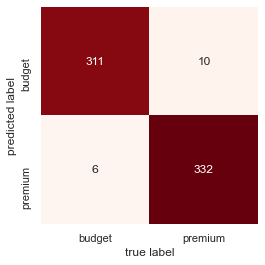

In [229]:
plt.figure(figsize=(4,4))
sns.heatmap(mat_fnn1, cmap="Reds", square=True, annot=True, fmt="d", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("true label")
plt.ylabel("predicted label");

In [226]:
print("Test accuracy: %f" %accuracy_score(y_test, y_pred_fnn1))
print("Test F1 score: %f" %f1_score(y_test, y_pred_fnn1))

Test accuracy: 0.975721
Test F1 score: 0.976471


### 4 hidden layers with 100, 100, 100, 50 units respectively

In [231]:
fnn_2 = MLPClassifier(hidden_layer_sizes=(100, 100, 100, 50), random_state=1).fit(X_train, y_train)

In [232]:
y_pred_fnn2 = fnn_2.predict(X_test)
mat_fnn2 = confusion_matrix(y_pred_fnn2, y_test)
mat_fnn2

array([[309,   9],
       [  8, 333]])

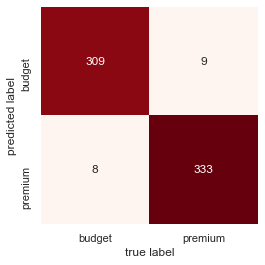

In [233]:
plt.figure(figsize=(4,4))
sns.heatmap(mat_fnn2, cmap="Reds", square=True, annot=True, fmt="d", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("true label")
plt.ylabel("predicted label");

In [234]:
print("Test accuracy: %f" %accuracy_score(y_test, y_pred_fnn2))
print("Test F1 score: %f" %f1_score(y_test, y_pred_fnn2))

Test accuracy: 0.974203
Test F1 score: 0.975110


### hyperparameter optimization

In [241]:
parameter_grid = {
    "hidden_layer_sizes": [(100,100,100,50), (100,)],
    "activation": ["tanh", "relu"],
    "solver": ["sgd", "adam"],
    "alpha": [0.0001, 0.05],
    "learning_rate": ["constant", "adaptive"],
}
fnn_gs = GridSearchCV(MLPClassifier(max_iter=100), parameter_grid, n_jobs=1, cv=5)

In [242]:
fnn_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(100, 100, 100, 50), (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [243]:
print("Best parameters:\n", fnn_gs.best_params_)

Best parameters:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


## Bidirectional LSTM recurrent neural network

<tr>
<td> <img src="tensorflow_demo.png" alt="Drawing" style="width: 400px;"> <td/>
<td> <img src="LSTM.png" alt="Drawing" style="width: 800px;"> <td/>
<tr/>

Source: [Text classification RNN](https://www.tensorflow.org/tutorials/text/text_classification_rnn) and [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [134]:
# use stemmed descriptions and class labels to create dataset
tf_train = tf.data.Dataset.from_tensor_slices((X_train_nb, y_train_nb))
tf_test = tf.data.Dataset.from_tensor_slices((X_test_nb, y_test_nb))
# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

In [92]:
for example, label in tf_train.take(1):
  print("text: ", example.numpy())
  print("label: ", label.numpy())

text:  b'senc beauti essenti daili care face wash featur gentl formula contain silk protein said remov impur leav skin feel soft refresh suitabl skin type product retail ml pack'
label:  0


In [93]:
for example, label in tf_test.take(1):
  print("text: ", example.numpy())
  print("label: ", label.numpy())

text:  b'zao essenc natur liquid lip balm relaunch avail new formula suitabl vegan use organ cocoa butter organ carnauba wax organ castor oil effect replac beeswax newli design ml pack refil reduc wast describ light refil balm velveti textur melt lip provid natur glossi effect product featur activ ingredi said intens moisturis lip elast natur shine use regularli protect harsh element cold wind sun formul organ cocoa butter protect skin extern factor element pollut help maintain hydrat slow loss water form barrier surfac epidermi act prevent care bring suppl skin cur care skin dri organ carnauba wax film agent protect skin produc continu film fix make skin suitabl type skin particularli suitabl sensit dri chap lip natur vegan balm contain natur origin ingredi contain gluten certifi cruelti free intern ecocert cosmo cosmet bio cosmetiqu come uniqu varnish bamboo case attract present bamboo pouch drawstr'
label:  1


In [135]:
BUFFER_SIZE = 500
BATCH_SIZE = 25

In [136]:
tf_train = tf_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
tf_test = tf_test.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [137]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(tf_train.map(lambda text, label: text))

In [120]:
np.array(encoder.get_vocabulary())[:20]

array(['', '[UNK]', 'skin', 'product', 'pack', 'ml', 'oil', 'retail',
       'natur', 'free', 'said', 'ingredi', 'formula', 'test', 'protect',
       'age', 'featur', 'extract', 'hydrat', 'formul'], dtype='<U14')

In [174]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=50,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [175]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=["accuracy"])

In [176]:
history = model.fit(tf_train, epochs=5,
                    validation_data=tf_test, 
                    validation_steps=10)

Epoch 1/5
106/106 [==============================] - 21s 195ms/step - loss: 0.6885 - accuracy: 0.5055 - val_loss: 0.6774 - val_accuracy: 0.4720
Epoch 2/5
106/106 [==============================] - 19s 183ms/step - loss: 0.4969 - accuracy: 0.7038 - val_loss: 0.1985 - val_accuracy: 0.9560
Epoch 3/5
106/106 [==============================] - 20s 187ms/step - loss: 0.1355 - accuracy: 0.9453 - val_loss: 0.0936 - val_accuracy: 0.9600
Epoch 4/5
106/106 [==============================] - 21s 194ms/step - loss: 0.0776 - accuracy: 0.9723 - val_loss: 0.0728 - val_accuracy: 0.9800
Epoch 5/5
106/106 [==============================] - 20s 188ms/step - loss: 0.0508 - accuracy: 0.9821 - val_loss: 0.0574 - val_accuracy: 0.9800


In [177]:
test_loss, test_acc = model.evaluate(tf_test)
print("Test Loss: %f" %test_loss)
print("Test Accuracy: %f" %test_acc)

27/27 [==============================] - 1s 27ms/step - loss: 0.0418 - accuracy: 0.9848
Test Loss: 0.041831
Test Accuracy: 0.984825


In [178]:
history.history

{'loss': [0.688513994216919,
  0.49688634276390076,
  0.1354915201663971,
  0.07763566821813583,
  0.050781987607479095],
 'accuracy': [0.5055070519447327,
  0.7037599682807922,
  0.9453095197677612,
  0.9722749590873718,
  0.9821496605873108],
 'val_loss': [0.6773914098739624,
  0.19854475557804108,
  0.09358254075050354,
  0.07277806103229523,
  0.05740882828831673],
 'val_accuracy': [0.47200000286102295,
  0.9559999704360962,
  0.9599999785423279,
  0.9800000190734863,
  0.9800000190734863]}

In [172]:
def plot_graphs(history, metric):
    x_label = np.arange(len(history.history[metric]))+1
    plt.plot(x_label, history.history[metric])
    plt.plot(x_label, history.history["val_"+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

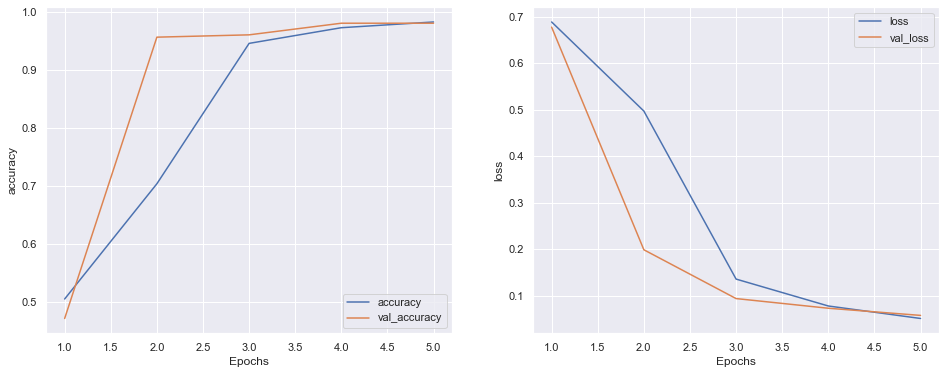

In [179]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.subplot(1,2,2)
plot_graphs(history, "loss")

In [208]:
model.predict(clean_input(sample_1))[0][0]

-0.32129997

In [214]:
# sigmoid
#1/(1 + np.exp(-model.predict(clean_input(sample_1))[0][0]))
tf.sigmoid(model.predict(clean_input(sample_2))[0][0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5965994>

In [199]:
def tf_predict(sample_input, model):
    label = model.predict(clean_input(sample_input))[0]
    if label < 0: return "budget"
    elif label >= 0: return "premium"

In [254]:
sample_1 = "This product moisturizes and relaxes skin."
sample_2 = "This product rejuvenates and reduces fine lines."
sample_3 = "sorbitol, glycerin, water, sea salt"
sample_4 = "retinol, hyaluronic acid, antioxidants"

In [291]:
tf_predict(sample_4, model)

'premium'

In [247]:
#tf_predict(sample_2, model)